# Wetland histograms

**Background**

**What does this notebook do?** This notebook generates histograms of raster properties for wetland and non-wetland regions in Queensland.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [1]:
import functools
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43029 Dashboard: /user/alger/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


In [3]:
dc = datacube.Datacube(app='wetland-histograms')

In [4]:
wetlands = gpd.read_file('Queensland_dominant_wetland_areas_22042020.shp')

In [5]:
tiles = gpd.read_file('QLDTestTiles.shp')

In [6]:
validity = wetlands.geometry.apply(explain_validity)

In [7]:
invalid = validity != 'Valid Geometry'

In [8]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands.loc[invalid, 'geometry'] = fixed_wetlands

## Load rasters

In [9]:
sampled_wetlands = wetlands.geometry.intersection(tiles.unary_union)

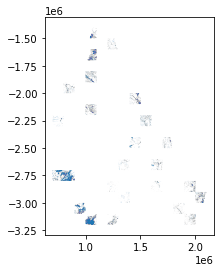

In [10]:
sampled_wetlands.plot()

In [11]:
wetlands = wetlands[~sampled_wetlands.geometry.is_empty]
wetlands.loc[:, 'geometry'] = sampled_wetlands[~sampled_wetlands.geometry.is_empty]

In [58]:
# Here's some ways to get the "non-wetlands" regions that we have tiles for.
# Super super slow! Don't do this.
# Better approach is to load the raster images that we have and then mask the wetlands.

# sampled_nonwetlands = tiles.copy()
# for i in tqdm(range(len(sampled_wetlands))):
#     sampled_nonwetlands = sampled_nonwetlands.difference(wetlands.iloc[i])

# sampled_nonwetlands = gpd.overlay(tiles, wetlands, how='difference')

In [12]:
tile = tiles.iloc[0]

In [13]:
query = {
    "geopolygon": datacube.utils.geometry.Geometry(tile.geometry, crs='EPSG:3577'),
    "time": '2018-01',
    "output_crs": 'EPSG:3577',
    "resolution": (-10, 10),
}

In [14]:
ds = dc.load('fc_percentile_albers_annual', **query)

In [53]:
ds_wofs = dc.load('wofs_filtered_summary', **query)

In [24]:
this_tile = gpd.clip(wetlands, tile.geometry)

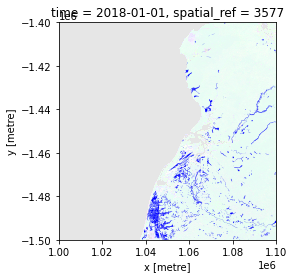

In [29]:
ax = plt.subplot(1, 1, 1)
rgb(ds, bands=['BS_PC_90', 'PV_PC_90', 'NPV_PC_90'], ax=ax, alpha=0.1)
this_tile.plot(ax=ax, facecolor='blue')

Rasterise this tile of wetlands so we can quickly mask.

In [47]:
raster_wetland = rasterio.features.rasterize(shapes=this_tile.buffer(0),
                                             out_shape=ds.y.shape + ds.x.shape,
                                             all_touched=False,
                                             default_value=1,
                                             fill=0,
                                             transform=ds.geobox.transform)

In [54]:
bs_w = ds.BS_PC_90.isel(time=0).values[raster_wetland.astype(bool)]
bs_nw = ds.BS_PC_90.isel(time=0).values[~raster_wetland.astype(bool)]

pv_w = ds.PV_PC_90.isel(time=0).values[raster_wetland.astype(bool)]
pv_nw = ds.PV_PC_90.isel(time=0).values[~raster_wetland.astype(bool)]

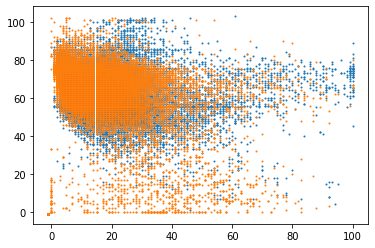

In [59]:
plt.scatter(bs_w[::100], pv_w[::100], s=1)
plt.scatter(bs_nw[::1000], pv_nw[::1000], s=1)